# Clustering Significant Earthquakes with DBSCAN

### Overview

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a powerful unsupervised clustering algorithm that groups points based on density and identifies outliers in the dataset. Unlike other clustering methods, it does not require specifying the number of clusters in advance and can find clusters of arbitrary shapes.

### Objective

In this notebook, we will:
1. Load a dataset of significant earthquakes from `significant_earthquakes.csv`.
2. Perform basic preprocessing to prepare the data for clustering.
3. Apply DBSCAN to identify clusters of earthquake occurrences and detect noise (outliers).
4. Visualize the clustering results on a 2D scatter plot.




## Introduction
We start by importing the necessary libraries.


In [5]:
import pandas as pd
import numpy as np

In [4]:
file_path = "/Users/ceciliaalberti/Documents/INDE_577/datasets/significant_earthquakes.csv"
df = pd.read_csv(file_path)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-11-26T13:47:03.695Z,37.0484,136.3492,10.000,6.1,mww,276,15,1.571,0.80,...,2024-11-27T20:38:01.427Z,"42 km WNW of Hakui, Japan",earthquake,6.22,1.720,0.036,73,reviewed,us,us
1,2024-11-15T05:28:29.617Z,-4.7021,153.3201,51.891,6.6,mww,50,67,1.260,1.35,...,2024-11-17T09:55:24.266Z,"123 km ESE of Kokopo, Papua New Guinea",earthquake,8.85,7.797,0.061,26,reviewed,us,us
2,2024-11-10T16:49:50.382Z,19.8116,-77.0391,14.000,6.8,mww,87,25,0.610,0.89,...,2024-11-17T01:36:29.648Z,"40 km SSW of Bartolomé Masó, Cuba",earthquake,2.61,1.655,0.032,94,reviewed,us,us
3,2024-10-30T20:15:19.812Z,43.5881,-127.7057,10.000,6.0,mww,107,69,2.658,0.95,...,2024-11-27T20:25:27.341Z,"272 km W of Bandon, Oregon",earthquake,8.05,1.747,0.036,73,reviewed,us,us


## DBScan algorithm


In [6]:
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    - point1: A numpy array representing the first point.
    - point2: A numpy array representing the second point.

    Returns:
    - A float representing the distance between the two points.
    """
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [7]:
def find_neighbors(data, point_idx, eps):
    """
    Find all neighboring points within the radius `eps` of a given point.

    Parameters:
    - data: A numpy array of shape (n_points, n_features), the dataset.
    - point_idx: An integer, the index of the point for which to find neighbors.
    - eps: A float, the radius of the neighborhood.

    Returns:
    - A list of indices of points that are within the `eps` radius of the given point.
    """
    neighbors = []
    for idx, point in enumerate(data):
        if euclidean_distance(data[point_idx], point) <= eps:
            neighbors.append(idx)
    return neighbors


In [8]:
def dbscan(data, eps, min_pts):
    """
    Perform Density-Based Spatial Clustering of Applications with Noise (DBSCAN).

    Parameters:
    - data: A numpy array of shape (n_points, n_features), the dataset.
    - eps: A float, the radius of the neighborhood for density estimation.
    - min_pts: An integer, the minimum number of points required to form a dense region.

    Returns:
    - labels: A list of integers where each entry corresponds to the cluster ID of a point.
              Noise points are labeled as -1.
    """
    n_points = len(data)
    labels = [-1] * n_points  # Initialize all points as noise (-1)
    cluster_id = 0  # Cluster counter

    for point_idx in range(n_points):
        # Skip if already labeled
        if labels[point_idx] != -1:
            continue
        
        # Find neighbors
        neighbors = find_neighbors(data, point_idx, eps)
        
        # Check if it's a core point
        if len(neighbors) < min_pts:
            labels[point_idx] = -1  # Mark as noise
            continue
        
        # Expand the cluster
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            
            # If neighbor is noise, include it in the cluster
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            
            # Skip if already labeled
            if labels[neighbor_idx] != -1:
                i += 1
                continue
            
            # Add this point to the cluster
            labels[neighbor_idx] = cluster_id
            
            # Expand the neighbors list
            new_neighbors = find_neighbors(data, neighbor_idx, eps)
            if len(new_neighbors) >= min_pts:
                neighbors += new_neighbors
            
            i += 1
        
        # Move to the next cluster
        cluster_id += 1

    return labels

## Data preparation


In [12]:
# Extract latitude and longitude for clustering
coordinates = df[['latitude', 'longitude']].to_numpy()
coordinates

array([[  37.0484,  136.3492],
       [  -4.7021,  153.3201],
       [  19.8116,  -77.0391],
       [  43.5881, -127.7057]])

In [13]:
# Set parameters
eps = 1  # Radius
min_pts = 2  # Minimum number of points in a neighborhood

# Apply DBSCAN
labels = dbscan(coordinates, eps, min_pts)

# Add the cluster labels back to the DataFrame
df['cluster'] = labels

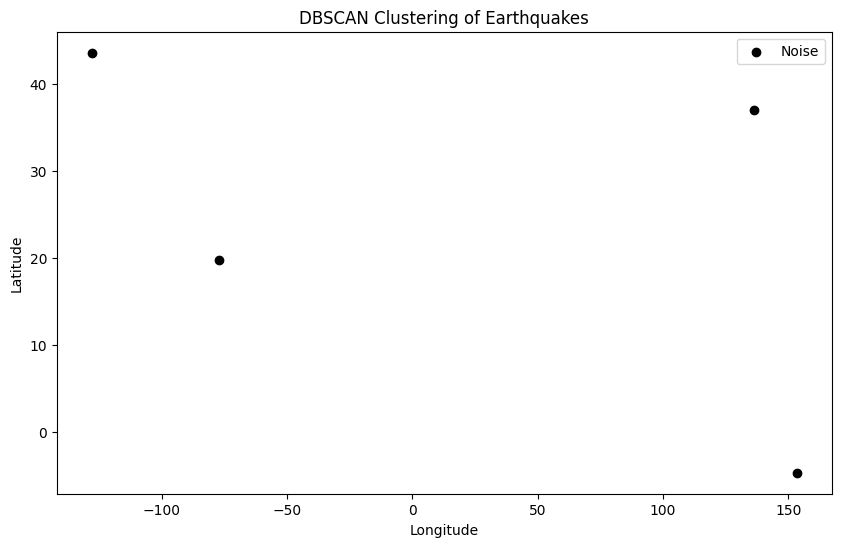

In [14]:
import matplotlib.pyplot as plt

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_id in set(labels):
    if cluster_id == -1:  # Noise points
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / len(set(labels)))
        label = f'Cluster {cluster_id}'
    
    plt.scatter(
        df.loc[df['cluster'] == cluster_id, 'longitude'],
        df.loc[df['cluster'] == cluster_id, 'latitude'],
        c=[color],
        label=label
    )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Earthquakes')
plt.legend()
plt.show()
